In [1]:
import os
import warnings
import numpy as np

from matplotlib import pyplot as plt
from pathlib import Path
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

warnings.filterwarnings('ignore')

In [2]:
path = Path('./')

In [ ]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession.builder.getOrCreate()

In [37]:
# Read the file with the label column into a DataFrame
optimal_dataset_path = path.parent / 'optimalDataset'

labels = spark.read.csv(str(optimal_dataset_path / 'labels.csv'), header=True)
labels = labels.withColumn("target", labels["target"].cast("tinyint"))
labels.show()

+--------------------+------+
|         customer_ID|target|
+--------------------+------+
|0000099d6bd597052...|     0|
|00000fd6641609c6e...|     0|
|00001b22f846c82c5...|     0|
|000041bdba6ecadd8...|     0|
|00007889e4fcd2614...|     0|
|000084e5023181993...|     0|
|000098081fde4fd64...|     0|
|0000d17a1447b25a0...|     0|
|0000f99513770170a...|     1|
|00013181a0c5fc8f1...|     1|
|0001337ded4e1c253...|     1|
|00013c6e1cec7c21b...|     1|
|0001812036f155833...|     1|
|00018dd4932409baf...|     0|
|000198b3dc70edd65...|     0|
|000201146e53cacdd...|     0|
|0002d381bdd8048d7...|     0|
|0002e335892f7998f...|     1|
|00031e8be98bc3411...|     0|
|000333075fb8ec6d5...|     1|
+--------------------+------+
only showing top 20 rows



In [41]:
df = spark.read.load(str(optimal_dataset_path / 'data.parquet'))
df.show()

+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+---

In [42]:
# merge
data = df.join(labels, on='customer_ID', how='left')
data.show()

+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--

# Algorithm

## Function to evaluate

In [43]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix

def evaluate(predict, validation_labels=None, format='report'):
    y_true, y_pred = validation_labels.collect(), predict.collect()
        
    if format == 'report':
        return classification_report(y_true, y_pred)
    else:   # metric f1 score
        return f1_score(y_true, y_pred)


def show_confusion_matrix(predict, validation_labels=None):
    y_true, y_pred = validation_labels.collect(), predict.collect()

    cf = np.array(confusion_matrix(y_true, y_pred))
    fig, ax = plt.subplots()
    im = ax.imshow(cf)

    # We want to show all ticks...
    ax.set_xticks(np.arange(cf.shape[1]))
    ax.set_yticks(np.arange(cf.shape[0]))
    # ... and label them with the respective list entries
    ax.set_xticklabels(['Predicted 0', 'Predicted 1'])
    ax.set_yticklabels(['True 0', 'True 1'])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(cf.shape[0]):
        for j in range(cf.shape[1]):
            text = ax.text(j, i, cf[i, j],
                        ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.show()


## Split dataset into train set and validation set

In [44]:
from pyspark.mllib.regression import LabeledPoint

# Split the DataFrame into training and validation sets
train_data, validation_data = data.randomSplit([0.8, 0.2], seed=42)

# Convert the training and validation data to RDDs of LabeledPoint objects
train_rdd = train_data.rdd.map(lambda row: LabeledPoint(row['target'], row[1:-1]))
validation_rdd = validation_data.rdd.map(lambda row: LabeledPoint(row['target'], row[1:-1]))

# Get labels
train_labels = train_rdd.map(lambda row: row.label)
validation_labels = validation_rdd.map(lambda row: row.label)

## Kmeans

In [ ]:
# Convert the training and validation data to RDDs of LabeledPoint objects
train_rdd_kmeans = train_rdd.map(lambda row: row.features)
validation_rdd_kmeans = validation_rdd.map(lambda row: row.features)

In [ ]:
from pyspark.mllib.clustering import KMeans

# Build the model (cluster the data)
kmeans = KMeans.train(train_rdd_kmeans, 2, maxIterations=50, initializationMode="random", seed=0)

# Predict
predict = validation_rdd_kmeans.map(lambda ad: kmeans.predict(ad))

In [ ]:
report = evaluate(predict, validation_labels)
print(report)

              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84     67817
         1.0       0.56      0.92      0.70     23856

    accuracy                           0.79     91673
   macro avg       0.76      0.83      0.77     91673
weighted avg       0.86      0.79      0.80     91673



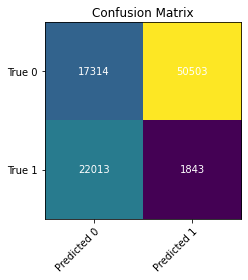

In [ ]:
# Visulization
show_confusion_matrix(predict, validation_labels)

## Decision Tree

In [ ]:
from pyspark.mllib.tree import DecisionTree

# Train the Decision Tree model on the training data
dt = DecisionTree.trainClassifier(train_rdd, numClasses=2, categoricalFeaturesInfo={},
                                     impurity='gini', maxDepth=10, maxBins=32)
# Predict
predict = dt.predict(validation_rdd.map(lambda row: row.features))

In [ ]:
report = evaluate(predict, validation_labels)
print(report)

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91     67817
         1.0       0.75      0.73      0.74     23856

    accuracy                           0.87     91673
   macro avg       0.83      0.82      0.82     91673
weighted avg       0.86      0.87      0.86     91673



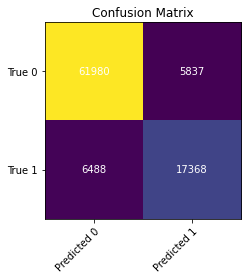

In [ ]:
# Visulization
show_confusion_matrix(predict, validation_labels)

## SVM 

In [ ]:
from pyspark.mllib.classification import SVMWithSGD

# Train the model
svm = SVMWithSGD.train(train_rdd, iterations=100, step=0.1, regParam=0.1)
# Predict
predict = svm.predict(validation_rdd.map(lambda row: row.features))

In [ ]:
report = evaluate(predict, validation_labels)
print(report)

              precision    recall  f1-score   support

         0.0       0.95      0.84      0.89     67817
         1.0       0.66      0.88      0.75     23856

    accuracy                           0.85     91673
   macro avg       0.80      0.86      0.82     91673
weighted avg       0.87      0.85      0.86     91673



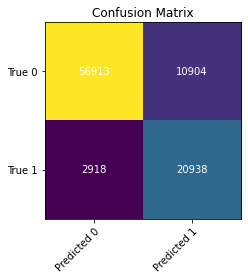

In [ ]:
# Visulization
show_confusion_matrix(predict, validation_labels)